# Praktikum 2

Pada percobaan kali ini kita akan membuat pencarian sederhana menggunakan FAISS. Install FAISS terlebih dahulu menggunakan FAISS-CPU, jika ingin menggunakan GPU, dapat lakukan instalasi FAISS-GPU.

Exact NN (Flat) indices: [[137 170 750]] distances: [[0.00013095 0.00077404 0.00079751]]
IVF+PQ indices: [[137 170 750]] distances: [[0.00012945 0.00079226 0.00080067]]
Waktu Exact: 0.0005431175231933594
Waktu IVF+PQ: 0.0009949207305908203


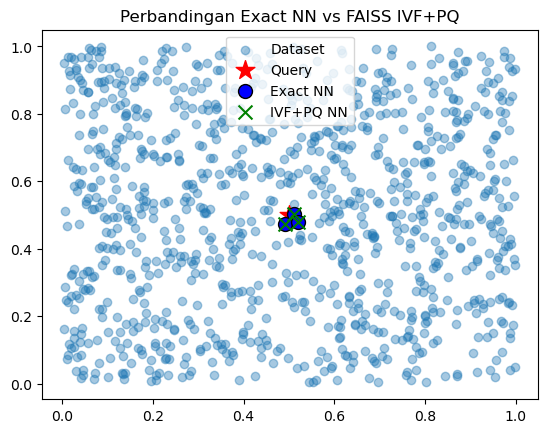

In [1]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

# 1. Buat dataset 2D sederhana
np.random.seed(42)
X = np.random.rand(1000, 2).astype('float32')  # 1000 titik 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query di tengah

# 2. Exact NN dengan IndexFlatL2 (brute force tapi cepat)
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # cari 3 tetangga terdekat
end = time.time()
time_flat = end - start

# 3. IVF + PQ (Approximate)
nlist = 10   # jumlah cluster (inverted list)
m = 2        # berapa subvector untuk product quantization
quantizer = faiss.IndexFlatL2(2)   # dipakai IVF untuk cluster awal
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

# 4. Print hasil
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

# 5. Visualisasi
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Tetangga dari Flat
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# Tetangga dari IVF+PQ
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Perbandingan Exact NN vs FAISS IVF+PQ")
plt.show()


Lakukan percobaan pada metric distance yang berbeda, 1000 vs 1jt data, 2D vs 5D data. catat hasilnya pada tabel yang anda buat sendiri seperti pada praktikum 1.

In [5]:
import numpy as np
import faiss
import pandas as pd
import time

# ------------------------------------
# 1️⃣ Setup parameter percobaan
# ------------------------------------
configs = [
    {"metric": "L2", "dim": 2, "n_data": 1000},
    {"metric": "L2", "dim": 5, "n_data": 1000},
    {"metric": "L2", "dim": 2, "n_data": 1_000_000},
    {"metric": "L2", "dim": 5, "n_data": 1_000_000},
    {"metric": "InnerProduct", "dim": 2, "n_data": 1000},
    {"metric": "InnerProduct", "dim": 5, "n_data": 1000},
    {"metric": "InnerProduct", "dim": 2, "n_data": 1_000_000},
    {"metric": "InnerProduct", "dim": 5, "n_data": 1_000_000},
]

results = []

# ------------------------------------
# 2️⃣ Loop percobaan
# ------------------------------------
for cfg in configs:
    metric = cfg["metric"]
    dim = cfg["dim"]
    n_data = cfg["n_data"]

    print(f"\n=== Percobaan: {metric}, {dim}D, {n_data} data ===")

    # Dataset acak
    np.random.seed(42)
    X = np.random.random((n_data, dim)).astype('float32')
    query = np.random.random((1, dim)).astype('float32')

    # Pilih jenis index berdasarkan metric
    if metric == "L2":
        index_flat = faiss.IndexFlatL2(dim)
    else:
        index_flat = faiss.IndexFlatIP(dim)

    # ---- Exact NN ----
    index_flat.add(X)
    start = time.time()
    D_flat, I_flat = index_flat.search(query, 3)
    time_flat = time.time() - start

    # ---- IVF+PQ ----
    nlist = 50   # jumlah cluster
    # cari m yang valid: harus membagi dim
    valid_m = [i for i in range(1, dim + 1) if dim % i == 0]
    m = valid_m[len(valid_m)//2] if valid_m else 1

    quantizer = faiss.IndexFlatL2(dim)
    try:
        if dim < 8:
            # untuk dim kecil, gunakan IVFFlat saja
            if metric == "L2":
                index_ivfpq = faiss.IndexIVFFlat(quantizer, dim, nlist, faiss.METRIC_L2)
            else:
                index_ivfpq = faiss.IndexIVFFlat(quantizer, dim, nlist, faiss.METRIC_INNER_PRODUCT)
        else:
            # gunakan IVF+PQ untuk dim besar
            if metric == "L2":
                index_ivfpq = faiss.IndexIVFPQ(quantizer, dim, nlist, m, 8)
            else:
                index_ivfpq = faiss.IndexIVFPQ(quantizer, dim, nlist, m, 8, faiss.METRIC_INNER_PRODUCT)

        # latih & uji
        index_ivfpq.train(X)
        index_ivfpq.add(X)
        start = time.time()
        D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
        time_ivfpq = time.time() - start

        # simpan hasil
        results.append({
            "Distance Metric": metric,
            "Dimensi": dim,
            "Jumlah Data": n_data,
            "Exact NN Index": I_flat[0].tolist(),
            "Approx NN Index": I_ivfpq[0].tolist(),
            "Waktu Exact (s)": round(time_flat, 6),
            "Waktu IVF/PQ (s)": round(time_ivfpq, 6)
        })

    except RuntimeError as e:
        print(f"⚠️ Gagal membuat IVF+PQ untuk dim={dim}: {e}")
        results.append({
            "Distance Metric": metric,
            "Dimensi": dim,
            "Jumlah Data": n_data,
            "Exact NN Index": I_flat[0].tolist(),
            "Approx NN Index": [],
            "Waktu Exact (s)": round(time_flat, 6),
            "Waktu IVF/PQ (s)": None
        })
        continue

# ------------------------------------
# 3️⃣ Tampilkan hasil
# ------------------------------------
df = pd.DataFrame(results)
print("\n=== Hasil Percobaan FAISS ===")
print(df)

# (Opsional) simpan ke CSV
# df.to_csv("hasil_faiss_experiment.csv", index=False)



=== Percobaan: L2, 2D, 1000 data ===

=== Percobaan: L2, 5D, 1000 data ===

=== Percobaan: L2, 2D, 1000000 data ===

=== Percobaan: L2, 5D, 1000000 data ===

=== Percobaan: InnerProduct, 2D, 1000 data ===

=== Percobaan: InnerProduct, 5D, 1000 data ===

=== Percobaan: InnerProduct, 2D, 1000000 data ===

=== Percobaan: InnerProduct, 5D, 1000000 data ===


WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points
WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points
WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points
WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points



=== Hasil Percobaan FAISS ===
  Distance Metric  Dimensi  Jumlah Data            Exact NN Index  \
0              L2        2         1000           [112, 535, 777]   
1              L2        5         1000            [988, 780, 27]   
2              L2        2      1000000  [132774, 119034, 511191]   
3              L2        5      1000000  [901095, 495168, 561017]   
4    InnerProduct        2         1000           [249, 712, 598]   
5    InnerProduct        5         1000            [210, 106, 49]   
6    InnerProduct        2      1000000  [489250, 265642, 659640]   
7    InnerProduct        5      1000000  [958577, 238618, 509273]   

            Approx NN Index  Waktu Exact (s)  Waktu IVF/PQ (s)  
0           [112, 777, 246]         0.000018          0.000024  
1            [988, 780, 27]         0.000011          0.000009  
2  [132774, 119034, 511191]         0.001668          0.000135  
3  [901095, 495168, 561017]         0.002014          0.000104  
4           [977, 932,